In [3]:
import gensim
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import spacy
import sklearn as sk

Import our topic modeling library `BERTopic` ([Documentation](https://maartengr.github.io/BERTopic/index.html)) and all its customizable components

In [ ]:
import bertopic
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.dimensionality import BaseDimensionalityReduction
import openai

The notebook relies on `dir` to locate the directory storing our data, in the form of csv files

In [6]:
dir = '../data'

# load data

In [7]:
train_dfs = [ pd.read_csv( f'{dir}/nlpdata-8606-cleansed.csv', encoding='utf8' ) ]
print( train_dfs[ 0 ].shape )
train_dfs[ 0 ].head()

(8577, 8)


,kewords,Label,Question,Answer,topic,sub-topic,source,qid
0,NaN,NaN,What were the sources of atmospheric nutrients...,The primary sources of atmospheric nutrients t...,NaN,NaN,NaN,0.0
1,NaN,NaN,How was the fertilization effect on phytoplank...,The fertilization effect on phytoplankton was ...,NaN,NaN,NaN,1.0
2,NaN,NaN,How do rising temperatures affect Alpine lakes?,Rising temperatures increase mineral weatherin...,NaN,NaN,NaN,2.0
3,NaN,NaN,How has an increase in phytoplankton biomass b...,Significant increase in phytoplankton biomass ...,NaN,NaN,NaN,3.0
4,NaN,NaN,How do higher metabolic rates of organisms and...,Higher metabolic rates of organisms and longer...,NaN,NaN,NaN,4.0


# preprocess (without lemmatization)

The only steps involved here are to concatentate `Question` and `Answer` and remove footnote numbers

In [8]:
for df in train_dfs:
    df[ 'text' ] = df.Question + ' ' + df.Answer.str.replace( r'\[[0-9]*\]', '' )

In [9]:
train_dfs[ 0 ].head()

,kewords,Label,Question,Answer,topic,sub-topic,source,qid,text
0,NaN,NaN,What were the sources of atmospheric nutrients...,The primary sources of atmospheric nutrients t...,NaN,NaN,NaN,0.0,What were the sources of atmospheric nutrients...
1,NaN,NaN,How was the fertilization effect on phytoplank...,The fertilization effect on phytoplankton was ...,NaN,NaN,NaN,1.0,How was the fertilization effect on phytoplank...
2,NaN,NaN,How do rising temperatures affect Alpine lakes?,Rising temperatures increase mineral weatherin...,NaN,NaN,NaN,2.0,How do rising temperatures affect Alpine lakes...
3,NaN,NaN,How has an increase in phytoplankton biomass b...,Significant increase in phytoplankton biomass ...,NaN,NaN,NaN,3.0,How has an increase in phytoplankton biomass b...
4,NaN,NaN,How do higher metabolic rates of organisms and...,Higher metabolic rates of organisms and longer...,NaN,NaN,NaN,4.0,How do higher metabolic rates of organisms and...


# train topic models

1. **Document embedding**: The sentence transformer `all-MiniLM-L6-v2` is used by default to create a vector embedding for each document. Other supported models can be considered when the quality of topics given by `all-MiniLM-L6-v2` is not good enough
1. **Dimensionality reduction**: The number of dimensions is by defaul 5. A larger number may be considered when it is believed finer granularity is needed to store the information for sentence similarity comparison. The default metric is cosine similarity. However, some points out Euclidean distance could be a better choice as UMAP relies on Euclidean space. [ref](https://github.com/lmcinnes/umap/issues/519)
1. **Document clustering**: The minimum cluster size in HDBSCAN can be tuned but the change is subtle.
1. **Weighing scheme**: enabling `bm25_weighing` and `reduce_frequent_words` may lead to overfitting.

In [10]:
def train( m, df ):
  docs = df.text
  # train topc model
  topics, probs = m.fit_transform( docs )
  return topics, probs

In [28]:
def calculate_coherence_score( m, df ):
  docs = df.text
  # calculate coherence score
  analyzer = m.vectorizer_model.build_analyzer()
  cleaned_docs = m._preprocess_text( docs )
  tokenized_docs = [ analyzer( doc ) for doc in cleaned_docs ]
  dictionary = gensim.corpora.Dictionary( tokenized_docs )
  return gensim.models.CoherenceModel(
    topics=[ [ topic for topic, freq in m.get_topic( i ) if topic in dictionary.token2id ] for i in range( len( set( m.get_topics() ) ) - 1 ) ],
    corpus=[ dictionary.doc2bow( doc ) for doc in tokenized_docs ],
    dictionary=dictionary,
    texts=tokenized_docs,
    coherence='c_v',
  ).get_coherence()

In [13]:
m = bertopic.BERTopic()
topics, probs = train( m, train_dfs[ 0 ] )
len( m.get_topics() )

155

In [29]:
calculate_coherence_score( m, train_dfs[ 0 ] )

0.55842331318718

# generate topic names

Topic names are generated based on the top 30 words in the bag of words in each topic

In [ ]:
topic_words = np.r_[ [ [ word for word, score in scored_words ] for k, scored_words in m.get_topics().items() ] ]
print( topic_words.shape )
topic_words[ :, 0 ]

In [ ]:
topic_nums = np.r_[ [ k for k in m.get_topics().keys() ] ]

In [ ]:
openai.organization = 'the-organization-id'
openai.api_key = 'a-valid-key'

In [ ]:
def generate_topic_name( words ):
  p = 'generate a topic name with no more than 3 words for the following words: ' + ', '.join( words )
  response = openai.Completion.create(
    model="text-davinci-003",
    prompt=p,
    temperature=0.9,
    max_tokens=150,
    top_p=1,
    frequency_penalty=1,
    presence_penalty=1
  )
  return response.choices[0].text.split('\n')[-1].strip()

In [ ]:
topic_names = { num: generate_topic_name( words ) for [ words, num ] in zip( topic_words[ :, : 30 ], topic_nums ) }

In [ ]:
train_dfs[ 0 ][ 'topic_words' ] = [ ', '.join( topic_words[ topic_num ] ) for topic_num in topics ]

In [ ]:
train_dfs[ 0 ][ 'topic_name' ] = [ topic_names[ topic_num ] for topic_num in topics ]

In [ ]:
train_dfs[ 0 ][ [ 'Question', 'Answer', 'topic_name', 'topic_words' ] ].to_csv(
    '8606-subtopics.csv',
    index=False,
)

# visualization

In [25]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [26]:
def create_wordcloud( model, topic ):
  words = { word: score for word, score in model.get_topic( topic ) }
  wc = WordCloud( max_words=100 )
  wc.generate_from_frequencies( words )
  plt.imshow( wc, interpolation='bilinear' )
  plt.axis( 'off' )
  plt.show()

topic #0


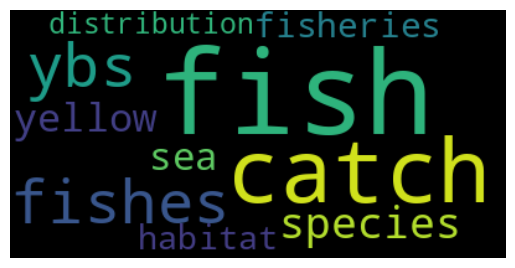

topic #1


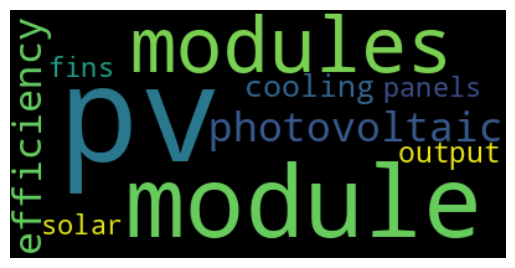

topic #2


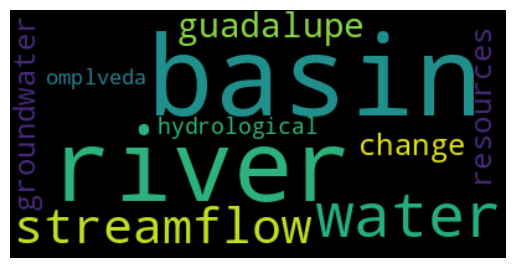

topic #3


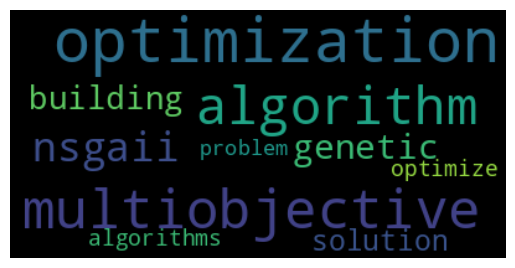

topic #4


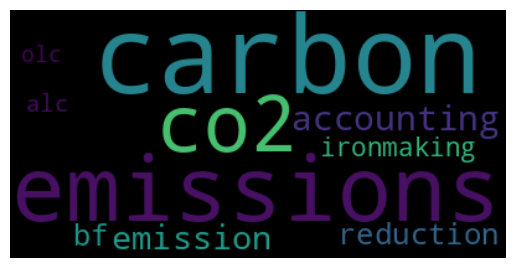

topic #5


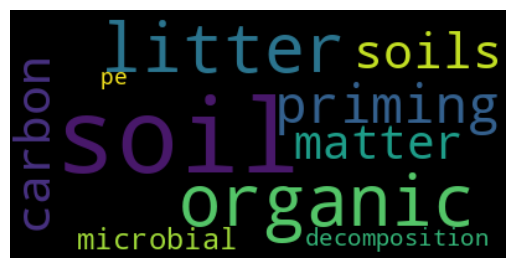

In [27]:
for i, topic in enumerate( m.get_topics() ):
  if topic >= 0:
    print( f'topic #{topic}' )
    create_wordcloud( m, topic )
  if i > 5:
    break